<a href="https://colab.research.google.com/github/KimaniKibuthu/Disaster-Tweets/blob/main/Natural_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disaster Tweets

Know which tweets are of disaster and which ones aren't

# Methodology
1. Data Obtainance
2. Data Preparation
3. Modelling

# Libraries and Variables

In [93]:
# Libraries

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding, Dense

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data Obtainance


In [50]:
# Obtain data
def setup(kaggle_name, kaggle_key):
  # Setup the username and ID
  os.environ["KAGGLE_USERNAME"] = kaggle_name
  os.environ["KAGGLE_KEY"] = kaggle_key

  print('Done')

In [51]:
# Get data
setup('kimanikibuthu', 'f85c0bb5d43058fddcce7902e1325677')

!kaggle competitions download -c nlp-getting-started

Done
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
# Load into variables
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

# Data Preparation

**General Inspection**

In [53]:
# View the data
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [54]:
# View test data
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [55]:
# Check for missing values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [56]:
# Get the text and target column
train_subset = train[['text', 'target']]

train_subset.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [57]:
# View target distribution
train_subset.target.value_counts(normalize=True)*100

0    57.034021
1    42.965979
Name: target, dtype: float64

**Text Preprocessing**

In [58]:
# text & target values
texts = train_subset['text'].values
target = train_subset['target'].values



In [59]:
# View texts to see preprocessing steps
for text in texts:
  print(text)

Streaming output truncated to the last 5000 lines.
Our doctors and nurses in the new Pediatric Emergency Department are all specialized in child services! http://t.co/k1TMLWvjmJ
#MissionHills CA #Nursing : Registered Nurse - Emergency Department ( Full Time... at Providence Health &amp; Services http://t.co/Z5grLREy6V
Just saw a car on the I-77 Fully engulfed in flames hahah
Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/P6cyLz5lpt http://t.co/Jpu9gIps9f
Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/CYzlshlQhG http://t.co/nDiS8f1vzt
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam
#TRAFFICALERT  Eastbound 210 Freeway at Citrus Ave in Azusa. Two motorcycles involved in accident with one fully engulfed in flames in lanes
Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/ldGWsYoWSs

In [86]:
# Define Tokenizer

def tokenizer(texts):
  # tokenize text
  n_texts = []
  for text in texts:
    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    text = ' '.join(tokens)
    n_texts.append(text)
  

  tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
  tokenizer.fit_on_texts(n_texts)
  #Get the word index
  word_index = tokenizer.word_index
  words = len(word_index) + 1

  # Create padded sequences
  sequences = tokenizer.texts_to_sequences(n_texts)
  seq_length = max([len(x) for x in sequences])
  padded_sentences = pad_sequences(sequences, maxlen=seq_length, padding='post')

  return padded_sentences, words, word_index




In [87]:
# Preprocess text

def preprocess_text(texts):
  new_texts = []
  for text in texts:
    # Make lower
    text = text.lower()

    # Remove url
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove placeholders
    text = re.sub(r"\[video\]", '', text)
    text = re.sub(r'{link}', '', text)

    # HTML and non letter characters
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', text)

    # Remove mentions
    text = re.sub('@[\w]+','', text)

    new_texts.append(text)

  # Tokenize texts
  
  padded_sentences, word_length, word_index = tokenizer(new_texts)

  return padded_sentences, word_length, word_index






In [88]:
# Prepare the texts for modelling
padded_texts, word_length, word_index = preprocess_text(texts)

['deed reason earthquake may allah forgive u', 'forest fire near la ronge sask canada', 'resident asked shelter place notified officer evacuation shelter place order expected', 'people receive wildfire evacuation order california', 'got sent photo ruby alaska smoke wildfire pours school', 'rockyfire update california hwy closed direction due lake county fire cafire wildfire', 'flood disaster heavy rain cause flash flooding street manitou colorado spring area', 'im top hill see fire wood', 'there emergency evacuation happening building across street', 'im afraid tornado coming area', 'three people died heat wave far', 'haha south tampa getting flooded hah wait second live south tampa gon na gon na fvck flooding', 'raining flooding florida tampabay tampa day ive lost count', 'flood bago myanmar arrived bago', 'damage school bus multi car crash breaking', 'whats man', 'love fruit', 'summer lovely', 'car fast', 'goooooooaaaaaal', 'ridiculous', 'london cool', 'love skiing', 'wonderful day',

In [81]:
# View shape
print(padded_texts.shape)
print(target.shape)


(7613, 23)
(7613,)


In [82]:
# Split data
x_train, x_prel, y_train, y_prel = train_test_split(padded_texts,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_prel, y_prel,
                                                test_size= 0.5,
                                                random_state=42)

In [115]:
x_train.shape

(6090, 23)

# Modelling
Two methods will be approached:
1. Using glove as an embedding layer and normal LSTM
2. Using BERT

## Glove & LSTM

In [65]:
# Get the embedding layer 
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.twitter.27B.zip \
    -o \content\glove.zip

^C


In [66]:
#Unzip the data
!unzip /content/glove.twitter.27B.zip


Archive:  /content/glove.twitter.27B.zip
replace glove.twitter.27B.25d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [67]:
embeddings_index = {}
with open('/content/glove.twitter.27B.25d.txt', 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  
  f.close()



In [68]:
# Create embeddings matrix

embedding_matrix = np.zeros((word_length, 25))
for word , i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [83]:
model = Sequential([
                        Embedding(word_length, 25, input_length=23, weights=[embedding_matrix], trainable=False),
                        Bidirectional(LSTM(10, return_sequences=True)),
                        Bidirectional(LSTM(10)),
                        Dense(16, activation='relu'),
                        Dense(16, activation='relu'),
                        Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer= adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [84]:

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=5)

  # reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.1,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)

callbacks = [early_stopper, reduce_lr]

In [85]:
history = model.fit(x_train, 
              y_train,
              batch_size = 16,
              epochs=50,
              validation_data = (x_val, y_val),
              callbacks = callbacks)

Epoch 1/50
381/381 [==============================] - 10s 15ms/step - loss: 0.5386 - accuracy: 0.7379 - val_loss: 0.4874 - val_accuracy: 0.7740
Epoch 2/50
381/381 [==============================] - 4s 11ms/step - loss: 0.4670 - accuracy: 0.7875 - val_loss: 0.4814 - val_accuracy: 0.7779
Epoch 3/50
381/381 [==============================] - 4s 11ms/step - loss: 0.4575 - accuracy: 0.7974 - val_loss: 0.4764 - val_accuracy: 0.7871
Epoch 4/50
381/381 [==============================] - 4s 11ms/step - loss: 0.4435 - accuracy: 0.8046 - val_loss: 0.4719 - val_accuracy: 0.7911
Epoch 5/50
381/381 [==============================] - 4s 11ms/step - loss: 0.4321 - accuracy: 0.8131 - val_loss: 0.4779 - val_accuracy: 0.7884
Epoch 6/50
381/381 [==============================] - 4s 11ms/step - loss: 0.4247 - accuracy: 0.8125 - val_loss: 0.4749 - val_accuracy: 0.7727

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
381/381 [==============================] - 4s 11

In [38]:
def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **accuracy**

    :param all: bool
    default=True. If true, overrides metric and plots figures of accuracy and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation accuracy',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train accuracy',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation accuracy plots',
                             xaxis_title='Epochs',
                             yaxis_title='accuracy')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['accuracy']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='accuracy',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='accuracy plot',
                             xaxis_title='Epochs',
                             yaxis_title='accuracy')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


In [89]:
plot_interactive_figures(history, 'accuracy')

## Using Bert

In [126]:
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert


In [104]:
!pip install tensorflow-text

In [106]:
import tensorflow_text as text

In [45]:
def bert_preprocess_text(texts):
  new_texts = []
  for text in texts:
    # Make lower
    text = text.lower()
    
    # Remove url
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove placeholders
    text = re.sub(r"\[video\]", '', text)
    text = re.sub(r'{link}', '', text)

    # HTML and non letter characters
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', text)

    # Remove mentions
    text = re.sub('@[\w]+','', text)

    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    text = ' '.join(tokens)
    new_texts.append(text)

  return new_texts

In [90]:
new_texts = bert_preprocess_text(texts)

In [153]:
# Split data
# Split data
x_train, x_prel, y_train, y_prel = train_test_split(new_texts,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_prel, y_prel,
                                                test_size= 0.5,
                                                random_state=42)

In [147]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_bert_model = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_bert_model}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [148]:
# Preprocess model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_bert_model, trainable=True)

In [149]:
# Tokenizer
vocab_file = bert_model.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_model.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [150]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [151]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [154]:
x_train = bert_encode(x_train, tokenizer, 30)
x_val = bert_encode(x_val, tokenizer, 30)
x_test = bert_encode(x_test, tokenizer, 30)

In [155]:
x_train

{'input_mask': <tf.Tensor: shape=(6090, 30), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(6090, 30), dtype=int32, numpy=
 array([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 1, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(6090, 30), dtype=int32, numpy=
 array([[  101, 87787, 13499, ...,     0,     0,     0],
        [  101, 10339, 10269, ...,   102,     0,     0],
        [  101, 41549, 29983, ...,     0,     0,     0],
        ...,
        [  101, 10209, 11620, ...,     0,     0,     0],
        [  101, 14731, 23763, ...,     0,     0,     0],
        [  101, 13059, 20207, ...,     0,    

In [156]:
!pip install -q tf-models-official
 

In [111]:
from official.nlp import optimization 

In [164]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [171]:
num_class = 1  # Based on available class selection
max_seq_length = 30  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [166]:
batch_size=16

In [172]:
epochs = 10
steps_per_epoch = np.ceil(len(x_train)/batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

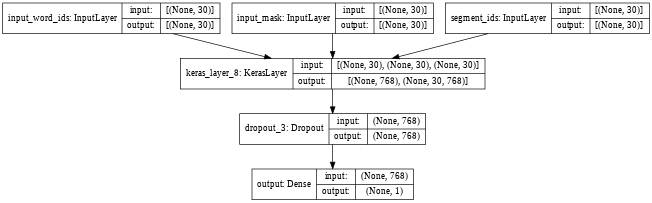

In [173]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [174]:

model.compile(optimizer=optimizer,
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

In [177]:
bert_history = model.fit(x_train, 
              y_train,
              batch_size = 16,
              epochs=epochs,
              validation_data = (x_val, y_val))
              #callbacks = callbacks)

Epoch 1/10
381/381 [==============================] - 69s 181ms/step - loss: 0.6850 - accuracy: 0.5696 - val_loss: 0.6845 - val_accuracy: 0.5690
Epoch 2/10
381/381 [==============================] - 70s 183ms/step - loss: 0.6857 - accuracy: 0.5700 - val_loss: 0.6845 - val_accuracy: 0.5690
Epoch 3/10
381/381 [==============================] - 70s 184ms/step - loss: 0.6853 - accuracy: 0.5701 - val_loss: 0.6845 - val_accuracy: 0.5690
Epoch 4/10
381/381 [==============================] - 71s 185ms/step - loss: 0.6845 - accuracy: 0.5685 - val_loss: 0.6845 - val_accuracy: 0.5690
Epoch 5/10
367/381 [===========================>..] - ETA: 2s - loss: 0.6862 - accuracy: 0.5686

KeyboardInterrupt: ignored